# **Build processed HALO training dataset**

This notebook merges the cleaned **interim** interaction datasets (Brochado, Cacace, ACDB) into a single processed table used for model training and figure generation.

## Inputs (interim, already cleaned per-source)
- `data/interim/source_a_brochado/brochado_cleaned_data.csv`
- `data/interim/source_b_cacace/cacace_cleaned_data.csv`
- `data/interim/source_c_acdb/acdb_cleaned_data_bliss.csv`

## Output (processed)
- `data/processed/halo_training_dataset.csv`

The output contains one row per **drug pair × strain** with a Bliss score and derived interaction label.


## Processing rules

### 1) Harmonized schema
All sources are reduced to the following columns before concatenation:
- `Drug A`, `Drug B`
- `Drug A Inchikey`, `Drug B Inchikey`
- `Drug Pair` (order-invariant key)
- `Strain`, `Specie`
- `Bliss Score`
- `Source`

### 2) Interaction labels from Bliss score
Interaction labels are derived from a single additivity cutoff:

- synergy: `Bliss Score ≤ -cutoff`
- additivity/neutral: `-cutoff < Bliss Score < cutoff`
- antagonism: `Bliss Score ≥ cutoff`

### 3) Duplicate handling (per Drug Pair × Strain)
If multiple rows exist for the same `Drug Pair × Strain`:
- **exact/near duplicates** (range ≤ δ): averaged into one row; sources merged.
- **conflict (n=2)**: both rows dropped.
- **conflict (n≥3)**: drop the farthest-from-median row, average the rest; sources merged.

This produces a single canonical Bliss score per `Drug Pair × Strain`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from halo.paths import INTERIM, PROCESSED

In [2]:
brochado_data = pd.read_csv(INTERIM / "source_a_brochado" / "brochado_cleaned_data.csv").copy()
cacace_data = pd.read_csv(INTERIM / "source_b_cacace" / "cacace_cleaned_data.csv").copy()
acdb_data_bliss =  pd.read_csv(INTERIM / "source_c_acdb" / "acdb_cleaned_data_bliss.csv").copy()

In [3]:
print(f'brochado: {len(brochado_data)}, cacace: {len(cacace_data)}, acdb_bliss: {len(acdb_data_bliss)}')

brochado: 2298, cacace: 862, acdb_bliss: 1148


In [4]:
from halo.mappers.drug_mapper import DrugMapper

mapper = DrugMapper()

## **Combining all three datasets - `halo_training_dataset.csv`**

In [5]:
brochado_data.head()

,Drug A,Drug B,Strain,Bliss Score,p-value,Interaction Type,Drug A Inchikey,Drug B Inchikey,Specie,Drug Pair
0,amoxicillin,oxacillin,escherichia coli bw25113,-0.5484,0.001666,Synergy,LSQZJLSUYDQPKJ-NJBDSQKTSA-N,UWYHMGVUTGAWSP-JKIFEVAISA-N,escherichia coli,"('LSQZJLSUYDQPKJ-NJBDSQKTSA-N', 'UWYHMGVUTGAWS..."
1,amoxicillin,cefsulodin,escherichia coli bw25113,-0.4577,0.001666,Synergy,LSQZJLSUYDQPKJ-NJBDSQKTSA-N,SYLKGLMBLAAGSC-QLVMHMETSA-N,escherichia coli,"('LSQZJLSUYDQPKJ-NJBDSQKTSA-N', 'SYLKGLMBLAAGS..."
2,amoxicillin,trimethoprim,escherichia coli bw25113,-0.1690,0.001666,Synergy,LSQZJLSUYDQPKJ-NJBDSQKTSA-N,IEDVJHCEMCRBQM-UHFFFAOYSA-N,escherichia coli,"('IEDVJHCEMCRBQM-UHFFFAOYSA-N', 'LSQZJLSUYDQPK..."
3,amoxicillin,acetylsalisylic acid,escherichia coli bw25113,-0.2265,0.001666,Synergy,LSQZJLSUYDQPKJ-NJBDSQKTSA-N,BSYNRYMUTXBXSQ-UHFFFAOYSA-N,escherichia coli,"('BSYNRYMUTXBXSQ-UHFFFAOYSA-N', 'LSQZJLSUYDQPK..."
4,chloramphenicol,fusidic acid,escherichia coli bw25113,-0.1602,0.001666,Synergy,WIIZWVCIJKGZOK-RKDXNWHRSA-N,IECPWNUMDGFDKC-MZJAQBGESA-N,escherichia coli,"('IECPWNUMDGFDKC-MZJAQBGESA-N', 'WIIZWVCIJKGZO..."


In [6]:
brochado_data['Strain'].value_counts()

Strain
escherichia coli bw25113        481
escherichia coli iai1           481
salmonella typhimurium lt2      377
salmonella typhimurium 14028    377
pseudomonas aeruginosa pao1     291
pseudomonas aeruginosa pa14     291
Name: count, dtype: int64

In [7]:
cacace_data.head()

,Drug A,Drug B,Strain,Bliss Score,p-value,Interaction Type,Drug A Inchikey,Drug B Inchikey,Specie,Drug Pair
0,cefotaxime,fluorouracil,staphylococcus aureus dsm 20231,-0.1143,0.029174,synergy,GPRBEKHLDVQUJE-QSWIMTSFSA-N,GHASVSINZRGABV-UHFFFAOYSA-N,staphylococcus aureus,"('GHASVSINZRGABV-UHFFFAOYSA-N', 'GPRBEKHLDVQUJ..."
1,fluorouracil,nitrofurantoin,staphylococcus aureus dsm 20231,-0.2047,0.004703,synergy,GHASVSINZRGABV-UHFFFAOYSA-N,NXFQHRVNIOXGAQ-YCRREMRBSA-N,staphylococcus aureus,"('GHASVSINZRGABV-UHFFFAOYSA-N', 'NXFQHRVNIOXGA..."
2,fluorouracil,streptomycin,staphylococcus aureus dsm 20231,-0.1847,0.002674,synergy,GHASVSINZRGABV-UHFFFAOYSA-N,UCSJYZPVAKXKNQ-HZYVHMACSA-N,staphylococcus aureus,"('GHASVSINZRGABV-UHFFFAOYSA-N', 'UCSJYZPVAKXKN..."
3,amoxicillin,celecoxib,staphylococcus aureus dsm 20231,0.1811,0.002674,antagonism,LSQZJLSUYDQPKJ-NJBDSQKTSA-N,RZEKVGVHFLEQIL-UHFFFAOYSA-N,staphylococcus aureus,"('LSQZJLSUYDQPKJ-NJBDSQKTSA-N', 'RZEKVGVHFLEQI..."
4,amoxicillin,clomiphene,staphylococcus aureus dsm 20231,-0.2366,0.006443,synergy,LSQZJLSUYDQPKJ-NJBDSQKTSA-N,GKIRPKYJQBWNGO-UHFFFAOYSA-N,staphylococcus aureus,"('GKIRPKYJQBWNGO-UHFFFAOYSA-N', 'LSQZJLSUYDQPK..."


In [8]:
cacace_data['Strain'].value_counts()

Strain
staphylococcus aureus dsm 20231    258
staphylococcus aureus newman       234
streptococcus pneumoniae           209
bacillus subtilis                  161
Name: count, dtype: int64

In [9]:
acdb_data_bliss.head()

,Drug A,Drug B,Strain,Bliss Score,Interaction Type,Method,PMID,Drug A Inchikey,Drug B Inchikey,Specie,Drug Pair
0,amikacin,puromycin,escherichia coli bw25113,-0.42,Synergy,Bliss,29973719,LKCWBDHBTVXHDL-RMDFUYIESA-N,RXWNCPJZOCPEPQ-NVWDDTSBSA-N,escherichia coli,"('LKCWBDHBTVXHDL-RMDFUYIESA-N', 'RXWNCPJZOCPEP..."
1,amikacin,trimethoprim,escherichia coli bw25113,0.09,Additivity,Bliss,29973719,LKCWBDHBTVXHDL-RMDFUYIESA-N,IEDVJHCEMCRBQM-UHFFFAOYSA-N,escherichia coli,"('IEDVJHCEMCRBQM-UHFFFAOYSA-N', 'LKCWBDHBTVXHD..."
2,amikacin,cefotaxime,escherichia coli bw25113,-0.08,Additivity,Bliss,29973719,LKCWBDHBTVXHDL-RMDFUYIESA-N,GPRBEKHLDVQUJE-QSWIMTSFSA-N,escherichia coli,"('GPRBEKHLDVQUJE-QSWIMTSFSA-N', 'LKCWBDHBTVXHD..."
3,amikacin,levofloxacin,escherichia coli bw25113,-0.04,Additivity,Bliss,29973719,LKCWBDHBTVXHDL-RMDFUYIESA-N,GSDSWSVVBLHKDQ-JTQLQIEISA-N,escherichia coli,"('GSDSWSVVBLHKDQ-JTQLQIEISA-N', 'LKCWBDHBTVXHD..."
4,amikacin,piperacillin,escherichia coli bw25113,-0.09,Additivity,Bliss,29973719,LKCWBDHBTVXHDL-RMDFUYIESA-N,IVBHGBMCVLDMKU-GXNBUGAJSA-N,escherichia coli,"('IVBHGBMCVLDMKU-GXNBUGAJSA-N', 'LKCWBDHBTVXHD..."


In [10]:
acdb_data_bliss['Strain'].value_counts()

Strain
escherichia coli bw25113        249
escherichia coli iai1           249
salmonella typhimurium lt2      185
salmonella typhimurium 14028    185
pseudomonas aeruginosa pao1     140
pseudomonas aeruginosa pa14     140
Name: count, dtype: int64

Visualizing bliss score across different sources to see if normalization is necessary:

/tmp/ipykernel_37016/3314914391.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_37016/3314914391.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


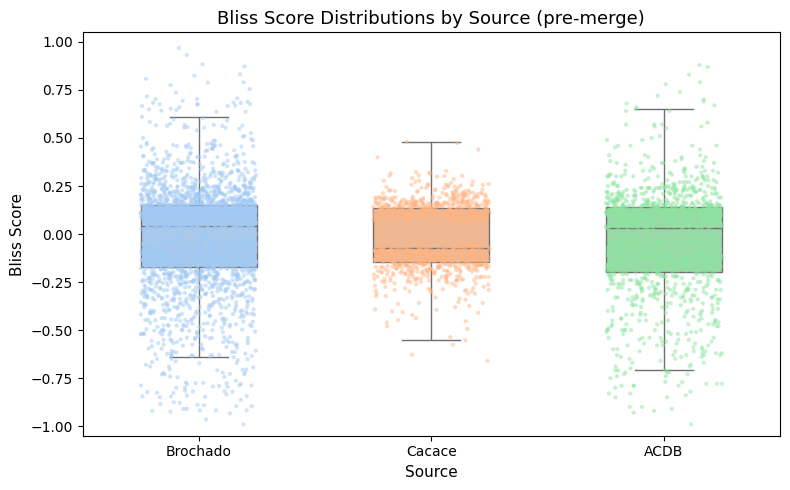

In [11]:
# --- inputs: your three pre-merge DataFrames ---
# rename these if yours differ
df_bro = brochado_data.copy()
df_cac = cacace_data.copy()
df_acd = acdb_data_bliss.copy()

score_col = 'Bliss Score'

df_plot = pd.concat([
    df_bro[[score_col]].assign(Source='Brochado'),
    df_cac[[score_col]].assign(Source='Cacace'),
    df_acd[[score_col]].assign(Source='ACDB')
], ignore_index=True)

# 2) Ensure numeric and clip to theoretical Bliss range
df_plot[score_col] = pd.to_numeric(df_plot[score_col], errors='coerce').clip(-1, 1)

# 3) Define consistent order
order = ['Brochado', 'Cacace', 'ACDB']

# 4) Plot
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_plot,
    x='Source',
    y=score_col,
    order=order,
    showfliers=False,
    width=0.5,
    palette='pastel'
)
sns.stripplot(
    data=df_plot,
    x='Source',
    y=score_col,
    order=order,
    alpha=0.5,
    jitter=0.25,
    size=3,
    palette='pastel'
)

plt.title("Bliss Score Distributions by Source (pre-merge)", fontsize=13)
plt.xlabel("Source", fontsize=11)
plt.ylabel("Bliss Score", fontsize=11)
plt.ylim(-1.05, 1.05)
plt.tight_layout()
plt.show()


In [12]:
df_plot.groupby('Source')['Bliss Score'].describe()[['mean','std','25%','50%','75%']]

,mean,std,25%,50%,75%
Source,,,,,
ACDB,-0.042091,0.286242,-0.20000,0.03000,0.14000
Brochado,-0.022432,0.283266,-0.16945,0.03950,0.14960
Cacace,-0.017645,0.176851,-0.14725,-0.07465,0.13675


In [13]:
# dropping the unnecessary cols
brochado_data = brochado_data[['Drug A', 'Drug B', 'Strain', 'Specie', 'Bliss Score', 'Drug Pair', 'Drug A Inchikey', 'Drug B Inchikey']]
cacace_data = cacace_data[['Drug A', 'Drug B', 'Strain', 'Specie', 'Bliss Score', 'Drug Pair', 'Drug A Inchikey', 'Drug B Inchikey']]
acdb_data_bliss = acdb_data_bliss[['Drug A', 'Drug B', 'Strain', 'Specie', 'Bliss Score', 'Drug Pair', 'Drug A Inchikey', 'Drug B Inchikey']]

In [14]:
brochado_data['Source'] = 'Brochado'
cacace_data['Source'] = 'Cacace'
acdb_data_bliss['Source'] = 'ACDB'

In [15]:
common_cols = list(set(brochado_data.columns) & set(cacace_data.columns) & set(acdb_data_bliss.columns))
halo_training_dataset = pd.concat([brochado_data[common_cols], cacace_data[common_cols], acdb_data_bliss[common_cols]])
len(halo_training_dataset)

4308

In [16]:
halo_training_dataset = halo_training_dataset[['Drug A', 'Drug B', 'Strain', 'Specie', 'Bliss Score', 'Source', 'Drug Pair', 'Drug A Inchikey', 'Drug B Inchikey']]
halo_training_dataset.head()

,Drug A,Drug B,Strain,Specie,Bliss Score,Source,Drug Pair,Drug A Inchikey,Drug B Inchikey
0,amoxicillin,oxacillin,escherichia coli bw25113,escherichia coli,-0.5484,Brochado,"('LSQZJLSUYDQPKJ-NJBDSQKTSA-N', 'UWYHMGVUTGAWS...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,UWYHMGVUTGAWSP-JKIFEVAISA-N
1,amoxicillin,cefsulodin,escherichia coli bw25113,escherichia coli,-0.4577,Brochado,"('LSQZJLSUYDQPKJ-NJBDSQKTSA-N', 'SYLKGLMBLAAGS...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,SYLKGLMBLAAGSC-QLVMHMETSA-N
2,amoxicillin,trimethoprim,escherichia coli bw25113,escherichia coli,-0.1690,Brochado,"('IEDVJHCEMCRBQM-UHFFFAOYSA-N', 'LSQZJLSUYDQPK...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,IEDVJHCEMCRBQM-UHFFFAOYSA-N
3,amoxicillin,acetylsalisylic acid,escherichia coli bw25113,escherichia coli,-0.2265,Brochado,"('BSYNRYMUTXBXSQ-UHFFFAOYSA-N', 'LSQZJLSUYDQPK...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,BSYNRYMUTXBXSQ-UHFFFAOYSA-N
4,chloramphenicol,fusidic acid,escherichia coli bw25113,escherichia coli,-0.1602,Brochado,"('IECPWNUMDGFDKC-MZJAQBGESA-N', 'WIIZWVCIJKGZO...",WIIZWVCIJKGZOK-RKDXNWHRSA-N,IECPWNUMDGFDKC-MZJAQBGESA-N


In [17]:
halo_training_dataset['Drug Pair'].value_counts()

Drug Pair
('GSDSWSVVBLHKDQ-JTQLQIEISA-N', 'MYSWGUAQZAJSOK-UHFFFAOYSA-N')    13
('YJQPYGGHQPGBLI-KGSXXDOSSA-N', 'YMDXZJFXQJVXBF-STHAYSLISA-N')    13
('AGOYDEPGAOXOCK-KCBOHYOISA-N', 'UNFWWIHTNXNPBV-WXKVUWSESA-N')    12
('GHXZTYHSJHQHIJ-UHFFFAOYSA-N', 'WIIZWVCIJKGZOK-RKDXNWHRSA-N')    12
('IEDVJHCEMCRBQM-UHFFFAOYSA-N', 'MQTOSJVFKKJCRP-BICOPXKESA-N')    12
                                                                  ..
('LJVAJPDWBABPEJ-PNUFFHFMSA-N', 'NWIBSHFKIJFRCO-WUDYKRTCSA-N')     1
('UWYHMGVUTGAWSP-JKIFEVAISA-N', 'VAOCPAMSLUNLGC-UHFFFAOYSA-N')     1
('BSYNRYMUTXBXSQ-UHFFFAOYSA-N', 'XFALPSLJIHVRKE-GFCCVEGCSA-N')     1
('MQTOSJVFKKJCRP-BICOPXKESA-N', 'UGTJLJZQQFGTJD-UHFFFAOYSA-N')     1
('AOJJSUZBOXZQNB-TZSSRYMLSA-N', 'MQTOSJVFKKJCRP-BICOPXKESA-N')     1
Name: count, Length: 1333, dtype: int64

In [18]:
halo_training_dataset['Bliss Score'].describe()

count    4308.000000
mean       -0.026713
std         0.266374
min        -0.990600
25%        -0.166200
50%         0.030000
75%         0.145000
max         0.969100
Name: Bliss Score, dtype: float64

In [19]:
(halo_training_dataset['Bliss Score'] % 0.0001).abs().max()

np.float64(9.999999999999999e-05)

### **Adding a cutoff and cleaning the response labels**

In [20]:
def classify_interaction(bliss):
    if bliss <= -0.1:
        return 'synergy'
    elif -0.1 < bliss < 0.1:
        return 'neutral'
    if bliss >= 0.1:
        return 'antagonism'

halo_training_dataset['Interaction Type'] = halo_training_dataset['Bliss Score'].apply(classify_interaction)

In [21]:
halo_training_dataset['Interaction Type'].value_counts()

Interaction Type
synergy       1676
antagonism    1672
neutral        960
Name: count, dtype: int64

In [22]:
# just to make sure
halo_training_dataset['Interaction Type'] = halo_training_dataset['Interaction Type'].str.strip()
halo_training_dataset['Interaction Type'] = halo_training_dataset['Interaction Type'].astype(str)
halo_training_dataset['Interaction Type'] = halo_training_dataset['Interaction Type'].str.lower()
halo_training_dataset.head()

,Drug A,Drug B,Strain,Specie,Bliss Score,Source,Drug Pair,Drug A Inchikey,Drug B Inchikey,Interaction Type
0,amoxicillin,oxacillin,escherichia coli bw25113,escherichia coli,-0.5484,Brochado,"('LSQZJLSUYDQPKJ-NJBDSQKTSA-N', 'UWYHMGVUTGAWS...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,UWYHMGVUTGAWSP-JKIFEVAISA-N,synergy
1,amoxicillin,cefsulodin,escherichia coli bw25113,escherichia coli,-0.4577,Brochado,"('LSQZJLSUYDQPKJ-NJBDSQKTSA-N', 'SYLKGLMBLAAGS...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,SYLKGLMBLAAGSC-QLVMHMETSA-N,synergy
2,amoxicillin,trimethoprim,escherichia coli bw25113,escherichia coli,-0.1690,Brochado,"('IEDVJHCEMCRBQM-UHFFFAOYSA-N', 'LSQZJLSUYDQPK...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,IEDVJHCEMCRBQM-UHFFFAOYSA-N,synergy
3,amoxicillin,acetylsalisylic acid,escherichia coli bw25113,escherichia coli,-0.2265,Brochado,"('BSYNRYMUTXBXSQ-UHFFFAOYSA-N', 'LSQZJLSUYDQPK...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,BSYNRYMUTXBXSQ-UHFFFAOYSA-N,synergy
4,chloramphenicol,fusidic acid,escherichia coli bw25113,escherichia coli,-0.1602,Brochado,"('IECPWNUMDGFDKC-MZJAQBGESA-N', 'WIIZWVCIJKGZO...",WIIZWVCIJKGZOK-RKDXNWHRSA-N,IECPWNUMDGFDKC-MZJAQBGESA-N,synergy


In [23]:
len(halo_training_dataset)

4308

### **Checking all the `Strain` and `Specie`:**

In [24]:
halo_training_dataset['Strain'].value_counts()

Strain
escherichia coli bw25113           730
escherichia coli iai1              730
salmonella typhimurium lt2         562
salmonella typhimurium 14028       562
pseudomonas aeruginosa pao1        431
pseudomonas aeruginosa pa14        431
staphylococcus aureus dsm 20231    258
staphylococcus aureus newman       234
streptococcus pneumoniae           209
bacillus subtilis                  161
Name: count, dtype: int64

In [25]:
halo_training_dataset['Specie'].value_counts()

Specie
escherichia coli            1460
salmonella typhimurium      1124
pseudomonas aeruginosa       862
staphylococcus aureus        492
streptococcus pneumoniae     209
bacillus subtilis            161
Name: count, dtype: int64

In [26]:
print("Strain NA count:", halo_training_dataset['Strain'].isna().sum())
print("Specie NA count:", halo_training_dataset['Specie'].isna().sum())

Strain NA count: 0
Specie NA count: 0


### **Looking for duplicated rows in the combined data:**

In [27]:
halo_training_dataset.columns

Index(['Drug A', 'Drug B', 'Strain', 'Specie', 'Bliss Score', 'Source',
       'Drug Pair', 'Drug A Inchikey', 'Drug B Inchikey', 'Interaction Type'],
      dtype='object')

In [28]:
halo_training_dataset.head()

,Drug A,Drug B,Strain,Specie,Bliss Score,Source,Drug Pair,Drug A Inchikey,Drug B Inchikey,Interaction Type
0,amoxicillin,oxacillin,escherichia coli bw25113,escherichia coli,-0.5484,Brochado,"('LSQZJLSUYDQPKJ-NJBDSQKTSA-N', 'UWYHMGVUTGAWS...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,UWYHMGVUTGAWSP-JKIFEVAISA-N,synergy
1,amoxicillin,cefsulodin,escherichia coli bw25113,escherichia coli,-0.4577,Brochado,"('LSQZJLSUYDQPKJ-NJBDSQKTSA-N', 'SYLKGLMBLAAGS...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,SYLKGLMBLAAGSC-QLVMHMETSA-N,synergy
2,amoxicillin,trimethoprim,escherichia coli bw25113,escherichia coli,-0.1690,Brochado,"('IEDVJHCEMCRBQM-UHFFFAOYSA-N', 'LSQZJLSUYDQPK...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,IEDVJHCEMCRBQM-UHFFFAOYSA-N,synergy
3,amoxicillin,acetylsalisylic acid,escherichia coli bw25113,escherichia coli,-0.2265,Brochado,"('BSYNRYMUTXBXSQ-UHFFFAOYSA-N', 'LSQZJLSUYDQPK...",LSQZJLSUYDQPKJ-NJBDSQKTSA-N,BSYNRYMUTXBXSQ-UHFFFAOYSA-N,synergy
4,chloramphenicol,fusidic acid,escherichia coli bw25113,escherichia coli,-0.1602,Brochado,"('IECPWNUMDGFDKC-MZJAQBGESA-N', 'WIIZWVCIJKGZO...",WIIZWVCIJKGZOK-RKDXNWHRSA-N,IECPWNUMDGFDKC-MZJAQBGESA-N,synergy


In [29]:
len(halo_training_dataset)

4308

Cheking same `Drug Pair + Strain + Bliss Score`:

In [30]:
halo_training_dataset = mapper.refine_combinations(halo_training_dataset, other_columns=['Strain', 'Bliss Score'])
len(halo_training_dataset)

numebr of repeated row: 17
duplicated rows:               Drug A          Drug B                       Strain  \
12          amikacin       pyocyanin     escherichia coli bw25113   
34          amikacin        colistin  pseudomonas aeruginosa pa14   
153        aztreonam    penicillin g        escherichia coli iai1   
292       cefotaxime       meropenem        escherichia coli iai1   
298       cefotaxime    levofloxacin  pseudomonas aeruginosa pa14   
377  chloramphenicol  nitrofurantoin  pseudomonas aeruginosa pa14   
429    ciprofloxacin      tobramycin  pseudomonas aeruginosa pa14   
488   clarithromycin       bleomycin   salmonella typhimurium lt2   
565         colistin       mupirocin     escherichia coli bw25113   
582         colistin      fosfomycin  pseudomonas aeruginosa pao1   
680       fosfomycin       pyocyanin     escherichia coli bw25113   
707       fosfomycin    levofloxacin  pseudomonas aeruginosa pa14   
715       fosfomycin    levofloxacin  pseudomonas aeruginos

4291

17 rows have dropped -> 4304  
making sure:

In [31]:
dup_exact = halo_training_dataset.duplicated(
    subset=['Drug Pair','Strain','Bliss Score'], keep=False).sum()
print("Exact duplicates remaining (should be 0):", dup_exact)


Exact duplicates remaining (should be 0): 0


### **Looking for inconsistant rows - bliss:**

In [32]:
halo_training_dataset.columns

Index(['Drug A', 'Drug B', 'Strain', 'Specie', 'Bliss Score', 'Source',
       'Drug Pair', 'Drug A Inchikey', 'Drug B Inchikey', 'Interaction Type'],
      dtype='object')

In [33]:
halo_training_dataset['Source'].value_counts()

Source
Brochado    2298
ACDB        1131
Cacace       862
Name: count, dtype: int64

checking for NA:

In [34]:
halo_training_dataset = mapper.check_na(halo_training_dataset, critical_columns=['Strain', 'Bliss Score', 'Drug Pair', 'Drug A Inchikey', 'Drug B Inchikey'])

No missing rows found in the critical columns.


In [35]:
len(halo_training_dataset)

4291

checking for outliers in Bliss Score:

In [36]:
print("\nAbs min / max:", halo_training_dataset['Bliss Score'].min(), halo_training_dataset['Bliss Score'].max())


Abs min / max: -0.9906 0.9691


In [37]:
Q1 = halo_training_dataset['Bliss Score'].quantile(0.25)
Q3 = halo_training_dataset['Bliss Score'].quantile(0.75)
IQR = Q3 - Q1
low_limit  = Q1 - 1.5 * IQR
high_limit = Q3 + 1.5 * IQR

outliers_global = halo_training_dataset[(halo_training_dataset['Bliss Score'] < low_limit) | (halo_training_dataset['Bliss Score'] > high_limit)]
print(f"Global outliers (|beyond 1.5×IQR|): {len(outliers_global)} rows")
print(outliers_global[['Drug A','Drug B','Specie','Bliss Score','Source']].head(500).to_string(index=False))

Global outliers (|beyond 1.5×IQR|): 173 rows
          Drug A               Drug B                 Specie  Bliss Score   Source
       oxacillin             cefaclor       escherichia coli      -0.6896 Brochado
     polymyxin b             curcumin       escherichia coli      -0.6509 Brochado
     polymyxin b            triclosan       escherichia coli      -0.7639 Brochado
      spiramycin             colistin       escherichia coli      -0.7051 Brochado
   cycloserine d        chlorhexidine       escherichia coli       0.6360 Brochado
       oxacillin          polymyxin b       escherichia coli       0.6423 Brochado
     clindamycin           tobramycin       escherichia coli       0.7357 Brochado
      spiramycin           tobramycin       escherichia coli       0.6830 Brochado
   spectinomycin             vanillin       escherichia coli      -0.8915 Brochado
     polymyxin b         fusidic acid       escherichia coli      -0.8462 Brochado
       aztreonam acetylsalisylic acid     

The 173 “outliers” are statistical, not biological outliers -> not eliminating them.  
Range = −0.99 to +0.97   
Theoretical Bliss range = [−1, +1]  
So these are valid extreme synergy or antagonism values, not data-entry mistakes. 

In [38]:
gsize = (halo_training_dataset
         .groupby(['Drug Pair','Strain']).size()
         .reset_index(name='n'))
multi = gsize[gsize['n'] > 1]
print("Groups with > 1 row:", len(multi))


Groups with > 1 row: 1131


Grouped by `Drug Pair + Strain`, then:  
* exact/near (range ≤ ε): averaged to a single row; sources merged.  
* conflict with n=2: dropped the group.  
* conflict with n≥3: dropped farthest from median, averaged the rest.  
Then kept a single canonical row per Drug Pair×Strain.

In [39]:
def summarize_groups(df: pd.DataFrame, group_cols: list = ['Drug Pair', 'Strain'], eps: float = 0.05) -> pd.DataFrame:
    """
    Find groups of inconsistent rows, where the Drug Pair and Strain is identical but Bliss Score is different
    Classify rows into exact/near/conflict
    """

    df = df.copy()
    g = (df.groupby(list(group_cols))['Bliss Score'].agg(n='count', n_valid=lambda s: s.notna().sum(),
                                                         bmin='min', bmax='max').reset_index())
    g = g[g['n_valid'] > 1].copy()
    g['range'] = g['bmax'] - g['bmin']

    tol = 1e-6
    g['status'] = np.where(g['range'] <= tol, 'exact',
                           np.where(g['range'] <= eps, 'near', 'conflict'))
    
    cat = pd.CategoricalDtype(categories=['conflict', 'near', 'exact'], ordered=True)
    g['status'] = g['status'].astype(cat)

    return g.sort_values(['status','range','n_valid'], ascending=[True, False, False]).reset_index(drop=True)

In [40]:
def stacked_view(df: pd.DataFrame, summary: pd.DataFrame, group_cols=('Drug Pair', 'Strain'), statuses=('conflict', 'near')) -> pd.DataFrame:
    keys = summary.loc[summary['status'].isin(statuses), list(group_cols)]
    if keys.empty:
        return pd.DataFrame(columns=list(df.columns) + ['n_valid', 'range', 'status'])
    
    members = keys.merge(df, on=list(group_cols), how='inner')
    ctx = summary[list(group_cols) + ['n_valid','range','status']]
    out = members.merge(ctx, on=list(group_cols), how='left')
    
    out = out.sort_values(list(group_cols) + ['Bliss Score']).reset_index(drop=True)
    return out

In [41]:
def handle_inconsistent_rows(
    df: pd.DataFrame,
    summary: pd.DataFrame,
    group_cols=('Drug Pair','Strain'),
    bliss_round: int | None = 4   # round the averaged Bliss so dup detection is stable
):
    x = df.copy()
    key_cols = list(group_cols)

    # Build lookups from summary (summary is already n_valid>1)
    s = summary.copy()
    s_idx = list(map(tuple, s[key_cols].to_records(index=False)))
    status_map  = dict(zip(s_idx, s['status'].astype(str)))
    nvalid_map  = dict(zip(s_idx, s['n_valid'].astype(int)))

    near_keys      = {k for k in s_idx if status_map[k] == 'near'}
    conflict_keys  = {k for k in s_idx if status_map[k] == 'conflict'}
    conflict_n2    = {k for k in s_idx if status_map[k] == 'conflict' and nvalid_map[k] == 2}
    conflict_ge3   = {k for k in s_idx if status_map[k] == 'conflict' and nvalid_map[k] >= 3}

    rows = []

    for key, sub in x.groupby(key_cols, dropna=False):
        key_t = tuple(key)

        if key_t in near_keys:
            # Average all values, keep ONE representative; keep original Source; merge sources
            rep = sub.iloc[0].copy()
            mean_b = float(sub['Bliss Score'].mean(skipna=True))
            if bliss_round is not None:
                mean_b = round(mean_b, bliss_round)
            rep['Bliss Score'] = mean_b
            if 'Source' in sub.columns: rep['Source'] = ';'.join(sorted(set(sub['Source'].astype(str))))
            rows.append(rep)

        elif key_t in conflict_n2:
            # Drop whole group
            continue

        elif key_t in conflict_ge3:
            # Drop farthest-from-median, average remaining, keep ONE; keep original Source of rep; merge sources
            med = float(np.median(sub['Bliss Score']))
            dev = (sub['Bliss Score'] - med).abs()
            idx_out = dev.idxmax()
            sub2 = sub.drop(index=idx_out)

            rep = sub2.iloc[0].copy()
            mean_b = float(sub2['Bliss Score'].mean(skipna=True))
            if bliss_round is not None:
                mean_b = round(mean_b, bliss_round)
            rep['Bliss Score'] = mean_b
            if 'Source' in sub2.columns: rep['Source'] = ';'.join(sorted(set(sub2['Source'].astype(str))))
            rows.append(rep)

        else:
            # Not near/conflict → leave ALL rows intact
            rows.append(sub)


    # Concatenate (rows contains both Series and DataFrames)
    cleaned = pd.concat([r if isinstance(r, pd.DataFrame) else pd.DataFrame([r]) for r in rows],
        ignore_index=True)

    # --- Audit (counts only; no new columns in cleaned)
    near_groups = s.loc[s['status'] == 'near', key_cols]
    conf = s.loc[s['status'] == 'conflict', key_cols + ['n_valid']]
    near_rows_before = int(s.loc[s['status'] == 'near', 'n_valid'].sum())
    near_groups_n = int(len(near_groups))
    conf_n2_groups = int((conf['n_valid'] == 2).sum())
    conf_ge3_groups = int((conf['n_valid'] >= 3).sum())

    audit = {
        'orig_rows': int(len(df)),
        'cleaned_rows': int(len(cleaned)),
        'near_groups': near_groups_n,
        'near_rows_before': near_rows_before,
        'near_rows_after': near_groups_n,              # one per group
        'conflict_groups_n2': conf_n2_groups,
        'conflict_groups_ge3': conf_ge3_groups,
        'conflict_rows_removed_n2': int((conf['n_valid'] == 2).sum() * 2),
        'conflict_rows_removed_ge3': conf_ge3_groups,  # dropped one per group
        'total_rows_removed_est':
            int(near_rows_before - near_groups_n + conf_n2_groups*2 + conf_ge3_groups*1)
    }

    # keep original column order only
    cleaned = cleaned[df.columns.tolist()].reset_index(drop=True)
    return cleaned, audit


In [42]:
# Build your summary exactly as you already do
summary = summarize_groups(halo_training_dataset, group_cols=['Drug Pair','Strain'], eps=0.05)

# Produce the stacked view if you want to eyeball first (unchanged function)
stacked = stacked_view(halo_training_dataset, summary, group_cols=('Drug Pair','Strain'),
                       statuses=('conflict','near'))

# Handle inconsistent rows per your rules
cleaned, audit = handle_inconsistent_rows(
    halo_training_dataset,
    summary,
    group_cols=('Drug Pair','Strain'),
    bliss_round=4
)

print(audit)

{'orig_rows': 4291, 'cleaned_rows': 3160, 'near_groups': 1131, 'near_rows_before': 2262, 'near_rows_after': 1131, 'conflict_groups_n2': 0, 'conflict_groups_ge3': 0, 'conflict_rows_removed_n2': 0, 'conflict_rows_removed_ge3': 0, 'total_rows_removed_est': 1131}


In [43]:
print("Groups with ≥2 valid:", len(summary))
print(summary['status'].value_counts(dropna=False))

# Peek the stacked rows
cols = ['Drug A','Drug B','Drug A Inchikey','Drug B Inchikey',
        'Specie','Bliss Score','Source','Drug Pair','n_valid','range','status']
# stacked.to_csv('inconsistent_rows_from_halo_training_dataset.csv', index=False)
print(stacked[cols].head(4000).to_string(index=False))

Groups with ≥2 valid: 1131
status
near        1131
conflict       0
exact          0
Name: count, dtype: int64
            Drug A             Drug B             Drug A Inchikey             Drug B Inchikey                 Specie  Bliss Score   Source                                                  Drug Pair  n_valid  range status
    clarithromycin         spiramycin AGOYDEPGAOXOCK-KCBOHYOISA-N ACTOXUHEUCPTEW-CEUOBAOPSA-N       escherichia coli       0.1000     ACDB (ACTOXUHEUCPTEW-CEUOBAOPSA-N, AGOYDEPGAOXOCK-KCBOHYOISA-N)        2 0.0011   near
        spiramycin     clarithromycin ACTOXUHEUCPTEW-CEUOBAOPSA-N AGOYDEPGAOXOCK-KCBOHYOISA-N       escherichia coli       0.1011 Brochado (ACTOXUHEUCPTEW-CEUOBAOPSA-N, AGOYDEPGAOXOCK-KCBOHYOISA-N)        2 0.0011   near
    clarithromycin         spiramycin AGOYDEPGAOXOCK-KCBOHYOISA-N ACTOXUHEUCPTEW-CEUOBAOPSA-N       escherichia coli       0.1100     ACDB (ACTOXUHEUCPTEW-CEUOBAOPSA-N, AGOYDEPGAOXOCK-KCBOHYOISA-N)        2 0.0012   near
     

`dropped_idx_in_conflict` = the original index (from your input DataFrame) of the row removed from that conflict group (the outlier).

In [44]:
cleaned.head()

,Drug A,Drug B,Strain,Specie,Bliss Score,Source,Drug Pair,Drug A Inchikey,Drug B Inchikey,Interaction Type
0,spiramycin,clarithromycin,escherichia coli bw25113,escherichia coli,0.1006,ACDB;Brochado,"(ACTOXUHEUCPTEW-CEUOBAOPSA-N, AGOYDEPGAOXOCK-K...",ACTOXUHEUCPTEW-CEUOBAOPSA-N,AGOYDEPGAOXOCK-KCBOHYOISA-N,antagonism
1,spiramycin,clarithromycin,escherichia coli iai1,escherichia coli,0.1106,ACDB;Brochado,"(ACTOXUHEUCPTEW-CEUOBAOPSA-N, AGOYDEPGAOXOCK-K...",ACTOXUHEUCPTEW-CEUOBAOPSA-N,AGOYDEPGAOXOCK-KCBOHYOISA-N,antagonism
2,spiramycin,chir-90,escherichia coli bw25113,escherichia coli,-0.2526,Brochado,"(ACTOXUHEUCPTEW-CEUOBAOPSA-N, FQYBTYFKOHPWQT-V...",ACTOXUHEUCPTEW-CEUOBAOPSA-N,FQYBTYFKOHPWQT-VGSWGCGISA-N,synergy
3,spiramycin,chir-90,escherichia coli iai1,escherichia coli,-0.2767,Brochado,"(ACTOXUHEUCPTEW-CEUOBAOPSA-N, FQYBTYFKOHPWQT-V...",ACTOXUHEUCPTEW-CEUOBAOPSA-N,FQYBTYFKOHPWQT-VGSWGCGISA-N,synergy
4,spiramycin,chir-90,salmonella typhimurium 14028,salmonella typhimurium,-0.3671,Brochado,"(ACTOXUHEUCPTEW-CEUOBAOPSA-N, FQYBTYFKOHPWQT-V...",ACTOXUHEUCPTEW-CEUOBAOPSA-N,FQYBTYFKOHPWQT-VGSWGCGISA-N,synergy


In [45]:
cols_to_drop = ['n_group', 'range_in_group', 'consolidation', 'dropped_idx_in_conflict']
halo_training_dataset = cleaned.drop(columns=cols_to_drop, errors='ignore')
len(halo_training_dataset)

3160

length of ombinations_combined in this stage = **3160**

In [46]:
halo_training_dataset.head()

,Drug A,Drug B,Strain,Specie,Bliss Score,Source,Drug Pair,Drug A Inchikey,Drug B Inchikey,Interaction Type
0,spiramycin,clarithromycin,escherichia coli bw25113,escherichia coli,0.1006,ACDB;Brochado,"(ACTOXUHEUCPTEW-CEUOBAOPSA-N, AGOYDEPGAOXOCK-K...",ACTOXUHEUCPTEW-CEUOBAOPSA-N,AGOYDEPGAOXOCK-KCBOHYOISA-N,antagonism
1,spiramycin,clarithromycin,escherichia coli iai1,escherichia coli,0.1106,ACDB;Brochado,"(ACTOXUHEUCPTEW-CEUOBAOPSA-N, AGOYDEPGAOXOCK-K...",ACTOXUHEUCPTEW-CEUOBAOPSA-N,AGOYDEPGAOXOCK-KCBOHYOISA-N,antagonism
2,spiramycin,chir-90,escherichia coli bw25113,escherichia coli,-0.2526,Brochado,"(ACTOXUHEUCPTEW-CEUOBAOPSA-N, FQYBTYFKOHPWQT-V...",ACTOXUHEUCPTEW-CEUOBAOPSA-N,FQYBTYFKOHPWQT-VGSWGCGISA-N,synergy
3,spiramycin,chir-90,escherichia coli iai1,escherichia coli,-0.2767,Brochado,"(ACTOXUHEUCPTEW-CEUOBAOPSA-N, FQYBTYFKOHPWQT-V...",ACTOXUHEUCPTEW-CEUOBAOPSA-N,FQYBTYFKOHPWQT-VGSWGCGISA-N,synergy
4,spiramycin,chir-90,salmonella typhimurium 14028,salmonella typhimurium,-0.3671,Brochado,"(ACTOXUHEUCPTEW-CEUOBAOPSA-N, FQYBTYFKOHPWQT-V...",ACTOXUHEUCPTEW-CEUOBAOPSA-N,FQYBTYFKOHPWQT-VGSWGCGISA-N,synergy


### fixing the labels again?  
so there is no inconsistent labels (`Interactio Type`) based on this new bliss scores

In [47]:
def classify_interaction(bliss):
    if bliss <= -0.1:
        return 'synergy'
    elif -0.1 < bliss < 0.1:
        return 'neutral'
    if bliss >= 0.1:
        return 'antagonism'

halo_training_dataset['Interaction Type'] = halo_training_dataset['Bliss Score'].apply(classify_interaction)

In [48]:
halo_training_dataset['Interaction Type'].value_counts()

Interaction Type
antagonism    1227
synergy       1222
neutral        711
Name: count, dtype: int64

In [49]:
halo_training_dataset.to_csv(PROCESSED / "halo_training_dataset.csv", index=False)

In [50]:
halo_training_dataset['Specie'].value_counts()

Specie
escherichia coli            962
salmonella typhimurium      754
pseudomonas aeruginosa      582
staphylococcus aureus       492
streptococcus pneumoniae    209
bacillus subtilis           161
Name: count, dtype: int64

In [51]:
halo_training_dataset['Strain'].value_counts()

Strain
escherichia coli bw25113           481
escherichia coli iai1              481
salmonella typhimurium 14028       377
salmonella typhimurium lt2         377
pseudomonas aeruginosa pa14        291
pseudomonas aeruginosa pao1        291
staphylococcus aureus dsm 20231    258
staphylococcus aureus newman       234
streptococcus pneumoniae           209
bacillus subtilis                  161
Name: count, dtype: int64

In [52]:
halo_training_dataset['Drug Pair'].value_counts()

Drug Pair
(CLKOFPXJLQSYAH-ABRJDSQDSA-N, VVZBFOKBSDGVGZ-UHFFFAOYSA-N)    9
(GSDSWSVVBLHKDQ-JTQLQIEISA-N, MYSWGUAQZAJSOK-UHFFFAOYSA-N)    9
(NWIBSHFKIJFRCO-WUDYKRTCSA-N, YJQPYGGHQPGBLI-KGSXXDOSSA-N)    8
(AOJJSUZBOXZQNB-TZSSRYMLSA-N, NWIBSHFKIJFRCO-WUDYKRTCSA-N)    8
(AGOYDEPGAOXOCK-KCBOHYOISA-N, UNFWWIHTNXNPBV-WXKVUWSESA-N)    8
                                                             ..
(LJVAJPDWBABPEJ-PNUFFHFMSA-N, VAOCPAMSLUNLGC-UHFFFAOYSA-N)    1
(KDLRVYVGXIQJDK-AWPVFWJPSA-N, MINDHVHHQZYEEK-HBBNESRFSA-N)    1
(KDLRVYVGXIQJDK-AWPVFWJPSA-N, RYYVLZVUVIJVGH-UHFFFAOYSA-N)    1
(KDLRVYVGXIQJDK-AWPVFWJPSA-N, UWYHMGVUTGAWSP-JKIFEVAISA-N)    1
(KDLRVYVGXIQJDK-AWPVFWJPSA-N, VAOCPAMSLUNLGC-UHFFFAOYSA-N)    1
Name: count, Length: 1333, dtype: int64

In [53]:
unique_drugs = pd.unique(pd.concat([halo_training_dataset['Drug A Inchikey'], halo_training_dataset['Drug B Inchikey']], ignore_index=True))
print("Total unique drugs:", len(unique_drugs))

Total unique drugs: 97


In [54]:
halo_training_dataset['Source'].value_counts()

Source
Brochado         1167
ACDB;Brochado    1131
Cacace            862
Name: count, dtype: int64

### **Checking drug and strains/species that are unique in each dataset:**

In [55]:
all_drugs = set(halo_training_dataset['Drug A']).union(set(halo_training_dataset['Drug B']))
len(all_drugs)

98

98 unique drugs are available in the final `halo_training_dataset` df.

In [56]:
brochado_drugs = set(brochado_data['Drug A']).union(set(brochado_data['Drug B']))
cacace_drugs = set(cacace_data['Drug A']).union(set(cacace_data['Drug B']))
acdb_drugs = set(acdb_data_bliss['Drug A']).union(set(acdb_data_bliss['Drug B']))

# sanity check: checking if these drugs are in the final combinations df since we have done some preprocessing in between:
brochado_infinal = brochado_drugs.intersection(all_drugs)
cacace_infinal = cacace_drugs.intersection(all_drugs)
acdb_infinal = acdb_drugs.intersection(all_drugs)

print(f"Number of unique drugs in the final dF: {len(all_drugs)}")
print(f"Brochado drugs: {len(brochado_infinal)} / out of {len(brochado_drugs)} remained in final df.")
print(f"Cacace drugs: {len(cacace_infinal)} / out of {len(cacace_drugs)} remained in final df.")
print(f"ACDB drugs: {len(acdb_infinal)} / out of {len(acdb_drugs)} remained in final df.")


Number of unique drugs in the final dF: 98
Brochado drugs: 66 / out of 66 remained in final df.
Cacace drugs: 73 / out of 73 remained in final df.
ACDB drugs: 41 / out of 45 remained in final df.


In [57]:
all_strains = set(halo_training_dataset['Strain'].unique())
brochado_strains = set(brochado_data['Strain'].unique())
cacace_strains = set(cacace_data['Strain'].unique())
acdb_strains = set(acdb_data_bliss['Strain'].unique())

brochado_strains_infinal = brochado_strains.intersection(all_strains)
cacace_strains_infinal = cacace_strains.intersection(all_strains)
acdb_strains_infinal = acdb_strains.intersection(all_strains)

print(f"Number of unique strains in the final dF: {len(all_strains)}")
print(f"Number of Brochado strains in final df: {len(brochado_strains_infinal)}")
print(f"Number of Cacace strains in final df: {len(cacace_strains_infinal)}")
print(f"Number of ACDB strains in final df: {len(acdb_strains_infinal)}")

Number of unique strains in the final dF: 10
Number of Brochado strains in final df: 6
Number of Cacace strains in final df: 4
Number of ACDB strains in final df: 6


In [58]:
all_species = set(halo_training_dataset['Specie'].unique())
brochado_species = set(brochado_data['Specie'].unique())
cacace_species = set(cacace_data['Specie'].unique())
acdb_species = set(acdb_data_bliss['Specie'].unique())

brochado_species_infinal = brochado_species.intersection(all_species)
cacace_species_infinal = cacace_species.intersection(all_species)
acdb_species_infinal = acdb_species.intersection(all_species)

print(f"Number of unique species in the final dF: {len(all_species)}")
print(f"Number of Brochado species in final df: {len(brochado_species_infinal)}")
print(f"Number of Cacace species  in final df: {len(cacace_species_infinal)}")
print(f"Number of ACDB species in final df: {len(acdb_species_infinal)}")

Number of unique species in the final dF: 6
Number of Brochado species in final df: 3
Number of Cacace species  in final df: 3
Number of ACDB species in final df: 3


getting those drugs and strains that were not included in Brochado or Cacace datsets:

In [59]:
missing_drugs = acdb_infinal - (brochado_infinal | cacace_infinal)
missing_strains = acdb_strains_infinal - (brochado_strains_infinal | cacace_strains_infinal)
missing_species = acdb_species_infinal - (brochado_species_infinal | cacace_species_infinal)

print(f"ACDB-ony drugs: {len(missing_drugs)}, strains: {len(missing_strains)}, species: {len(missing_species)}")

ACDB-ony drugs: 0, strains: 0, species: 0


In [60]:
acdb_species_infinal

{'escherichia coli', 'pseudomonas aeruginosa', 'salmonella typhimurium'}

In [61]:
brochado_species_infinal

{'escherichia coli', 'pseudomonas aeruginosa', 'salmonella typhimurium'}

In [62]:
acdb_strains_infinal

{'escherichia coli bw25113',
 'escherichia coli iai1',
 'pseudomonas aeruginosa pa14',
 'pseudomonas aeruginosa pao1',
 'salmonella typhimurium 14028',
 'salmonella typhimurium lt2'}

In [63]:
brochado_strains_infinal

{'escherichia coli bw25113',
 'escherichia coli iai1',
 'pseudomonas aeruginosa pa14',
 'pseudomonas aeruginosa pao1',
 'salmonella typhimurium 14028',
 'salmonella typhimurium lt2'}

Seem like all the drugs and strains/species of the ACDB data has already in Brochado or Cacace!

## **Checking the Bliss score's distribution and range - for regression**
in Brochado, Cacace, ACDB, and combined dataset

Text(0.5, 1.0, 'Histogram of Bliss score in Brochado dataset')

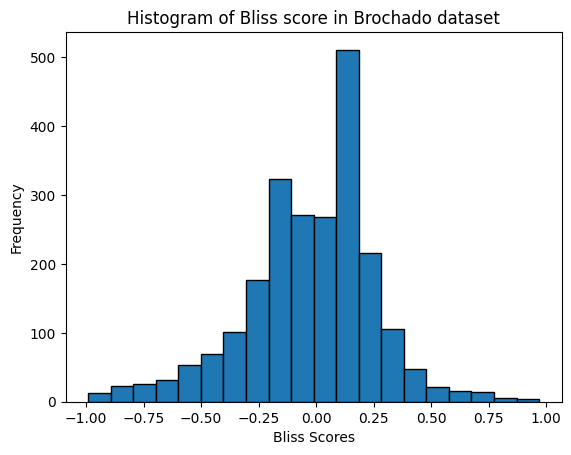

In [64]:
plt.hist(brochado_data['Bliss Score'], bins=20, edgecolor='black')
plt.xlabel('Bliss Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Bliss score in Brochado dataset')

Text(0.5, 1.0, 'Histogram of Bliss score in Cacace dataset')

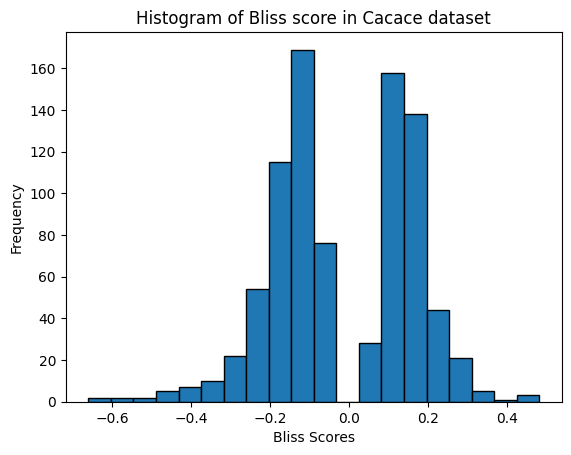

In [65]:
plt.hist(cacace_data['Bliss Score'], bins=20, edgecolor='black')
plt.xlabel('Bliss Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Bliss score in Cacace dataset')

Text(0.5, 1.0, 'Histogram of Bliss score in ACDB dataset')

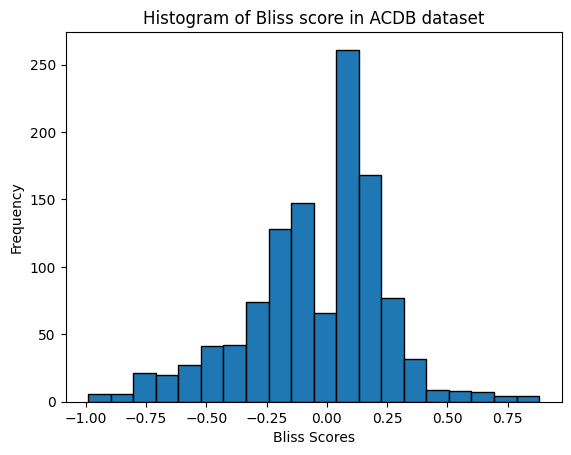

In [66]:
plt.hist(acdb_data_bliss['Bliss Score'], bins=20, edgecolor='black')
plt.xlabel('Bliss Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Bliss score in ACDB dataset')

Text(0.5, 1.0, 'Histogram of Bliss score in final dataset')

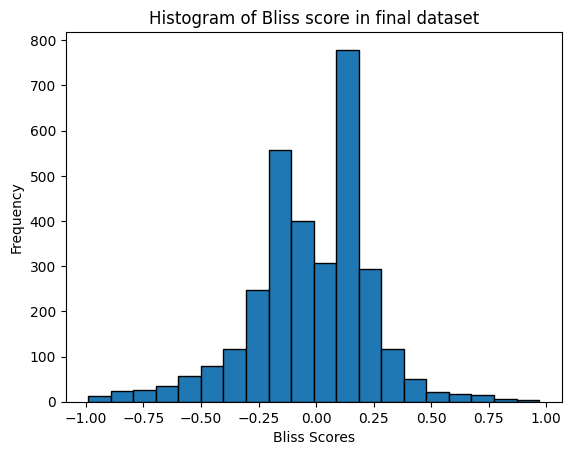

In [67]:
plt.hist(halo_training_dataset['Bliss Score'], bins=20, edgecolor='black')
plt.xlabel('Bliss Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Bliss score in final dataset')

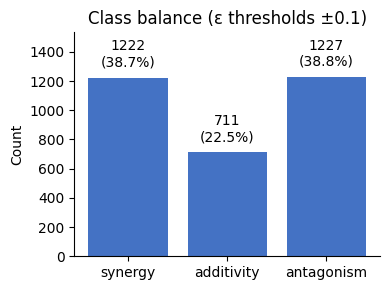

In [68]:
col = "Interaction Type"
EPS_THRESH = 0.1

normalize = {
    "neutral": "additivity"
}

labels = halo_training_dataset[col].replace(normalize)
order = ["synergy", "additivity", "antagonism"]
labels = pd.Categorical(labels, categories=order, ordered=True)
counts = labels.value_counts().reindex(order, fill_value=0)

# Percentages
pct = (counts / counts.sum() * 100).round(1)

# --- PLOT ---
fig, ax = plt.subplots(figsize=(4.0, 3.0))
bars = ax.bar(counts.index, counts.values, color="#4472C4")
ax.bar_label(
    bars,
    labels=[f"{c}\n({p}%)" for c, p in zip(counts.values, pct.values)],
    label_type='edge',
    padding=6
)
ax.set_ylim(0, max(counts.values) * 1.25)

ax.set_ylabel("Count")
ax.set_title("Class balance (ε thresholds ±0.1)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()